In [10]:
# Notebook constants (for static analysis and quick reruns)
from pathlib import Path
DATA_DIR = Path(r"C:\Users\mommy\Documents\market-recognition\dataset")
TRAIN_DIR = DATA_DIR / 'train'
OUTPUT_DIR = Path(r"C:\Users\mommy\Documents\market-recognition\model\run_10epochs")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 1e-3
FINE_TUNE = False
COMPUTE_FROM_GENERATORS = True

print('Constants:')
print(' DATA_DIR =', DATA_DIR)
print(' OUTPUT_DIR =', OUTPUT_DIR)

Constants:
 DATA_DIR = C:\Users\mommy\Documents\market-recognition\dataset
 OUTPUT_DIR = C:\Users\mommy\Documents\market-recognition\model\run_10epochs


In [12]:
# Debug evaluation-from-generators (verbose)
from pathlib import Path
import traceback
import sys
import time
import numpy as np

# Adjust these if needed
OUTPUT_DIR = Path(
    r"C:\Users\mommy\Documents\market-recognition\model\run_10epochs")
MODEL_PATH = OUTPUT_DIR / "product_classifier.keras"
DATA_DIR = Path(r"C:\Users\mommy\Documents\market-recognition\dataset")
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR = DATA_DIR / "validation"

# make small so it runs fast (5%); reduce to 0.01 if it's slow
SAMPLE_FRAC = 0.05
BATCH_SIZE = 16

print("Starting debug run at", time.strftime("%Y-%m-%d %H:%M:%S"))
print("OUTPUT_DIR:", OUTPUT_DIR.exists(), OUTPUT_DIR)
print("MODEL_PATH:", MODEL_PATH.exists(), MODEL_PATH)
print("TRAIN_DIR:", TRAIN_DIR.exists(), TRAIN_DIR)
print("VAL_DIR:", VAL_DIR.exists(), VAL_DIR)

if not MODEL_PATH.exists():
    raise FileNotFoundError(f"Model not found: {MODEL_PATH}")
if not TRAIN_DIR.exists() or not VAL_DIR.exists():
    raise FileNotFoundError(
        f"Train/validation dirs not found under {DATA_DIR}")

try:
    import tensorflow as tf
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    print("TF version:", tf.__version__)
except Exception as e:
    print("Failed importing TF:", e)
    raise

try:
    print("Loading model...")
    model = tf.keras.models.load_model(MODEL_PATH)
    print("Model loaded OK.")
except Exception:
    print("Error loading model:")
    traceback.print_exc()
    raise


def make_small_gen(path, frac):
    datagen = ImageDataGenerator(rescale=1.0/255)
    gen = datagen.flow_from_directory(path, target_size=(224, 224),
                                      batch_size=BATCH_SIZE, shuffle=True, class_mode='categorical')
    n = max(1, int(np.floor(gen.samples * frac)))
    steps = max(1, int(np.ceil(n / gen.batch_size)))
    return gen, n, steps


try:
    print("Preparing train subset generator...")
    tgen, t_n, t_steps = make_small_gen(TRAIN_DIR, SAMPLE_FRAC)
    print(f"Train samples: {tgen.samples}, subset n={t_n}, steps={t_steps}")
    print("Preparing val subset generator...")
    vgen, v_n, v_steps = make_small_gen(VAL_DIR, SAMPLE_FRAC)
    print(f"Val   samples: {vgen.samples}, subset n={v_n}, steps={v_steps}")
except Exception:
    print("Error creating generators:")
    traceback.print_exc()
    raise

try:
    print("Evaluating train subset (this will print per-step progress)...")
    t_res = model.evaluate(tgen, steps=t_steps, verbose=1)
    print("Train eval result:", t_res)
except Exception:
    print("Error during train evaluate:")
    traceback.print_exc()

try:
    print("Evaluating val subset (this will print per-step progress)...")
    v_res = model.evaluate(vgen, steps=v_steps, verbose=1)
    print("Val eval result:", v_res)
except Exception:
    print("Error during val evaluate:")
    traceback.print_exc()

print("Done. If still no output: check kernel status, notebook logs, or reduce SAMPLE_FRAC further.")

Starting debug run at 2025-12-31 00:07:26
OUTPUT_DIR: True C:\Users\mommy\Documents\market-recognition\model\run_10epochs
MODEL_PATH: True C:\Users\mommy\Documents\market-recognition\model\run_10epochs\product_classifier.keras
TRAIN_DIR: True C:\Users\mommy\Documents\market-recognition\dataset\train
VAL_DIR: True C:\Users\mommy\Documents\market-recognition\dataset\validation
TF version: 2.20.0
Loading model...


c:\Users\mommy\miniconda3\envs\marketrec\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model loaded OK.
Preparing train subset generator...
Found 12497 images belonging to 39 classes.
Train samples: 12497, subset n=624, steps=39
Preparing val subset generator...
Found 2674 images belonging to 39 classes.
Val   samples: 2674, subset n=133, steps=9
Evaluating train subset (this will print per-step progress)...
39/39 ━━━━━━━━━━━━━━━━━━━━ 25s 418ms/step - accuracy: 0.9936 - loss: 0.0118
Train eval result: [0.01183925848454237, 0.9935897588729858]
Evaluating val subset (this will print per-step progress)...
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 446ms/step - accuracy: 1.0000 - loss: 6.0004e-04
Val eval result: [0.0006000369321554899, 1.0]
Done. If still no output: check kernel status, notebook logs, or reduce SAMPLE_FRAC further.


# Fresh Evaluation Notebook
This notebook provides a clean, reproducible evaluation workflow for the current trained model: readiness checks, full test-set evaluation, optional ROC/AUC computation, a quick single-image test, and a documentation template. Run cells incrementally.

In [2]:
#Paths and knobs
from pathlib import Path

# Use absolute workspace paths provided by the user
DATA_DIR = Path(r"C:\Users\mommy\Documents\market-recognition\dataset")
TRAIN_DIR = str(DATA_DIR / 'train')
# point OUTPUT_DIR to the specific run that contains the saved model artifacts
OUTPUT_DIR = str(Path(r"C:\Users\mommy\Documents\market-recognition\model\run_10epochs"))
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 1e-3
FINE_TUNE = False

print('DATA_DIR =', DATA_DIR)
print('TRAIN_DIR =', TRAIN_DIR)
print('OUTPUT_DIR =', OUTPUT_DIR)


DATA_DIR = C:\Users\mommy\Documents\market-recognition\dataset
TRAIN_DIR = C:\Users\mommy\Documents\market-recognition\dataset\train
OUTPUT_DIR = C:\Users\mommy\Documents\market-recognition\model\run_10epochs


In [4]:
# GPU / TF check
import tensorflow as tf

# Use getattr to access `config` to avoid static-analysis warnings from Pylance
tf_config = getattr(tf, 'config', None)
if tf_config is not None:
    gpus = tf_config.list_physical_devices('GPU')
    if gpus:
        print('GPUs detected:')
        for g in gpus:
            print('-', g)
    else:
        print('No GPU detected; training/eval will run on CPU.')
else:
    # Fallback message when the `config` attribute isn't exposed in stubs/build
    print('TensorFlow `config` API not detected; running on CPU (or TF build without config exposure).')


No GPU detected; training/eval will run on CPU.


In [ ]:
#Readiness check for evaluation
from pathlib import Path
import json

MODEL_PATH = Path(OUTPUT_DIR) / "product_classifier.keras"
LABELS = Path(OUTPUT_DIR) / "labels.txt"

#Candidate test directories (prefer dataset in repo)
REPO_ROOT = Path('.').resolve()
CANDIDATES = [REPO_ROOT / 'dataset' / 'test', Path(TRAIN_DIR).parent / 'test', REPO_ROOT / 'test']
TEST_DIR = next((p for p in CANDIDATES if p.exists()), CANDIDATES[0])

print('Model path:', MODEL_PATH)
print('Model exists:', MODEL_PATH.exists())
print('Labels file exists:', LABELS.exists())
print('Selected test dir:', TEST_DIR)
print('Test dir exists:', TEST_DIR.exists())

readiness = {
    'model_exists': MODEL_PATH.exists(),
    'labels_exists': LABELS.exists(),
    'test_dir': str(TEST_DIR),
    'test_dir_exists': TEST_DIR.exists(),
}

# Save readiness summary
out = Path(OUTPUT_DIR)
out.mkdir(parents=True, exist_ok=True)
(out / 'readiness.json').write_text(json.dumps(readiness, indent=2))
print('\nWrote readiness.json to', out / 'readiness.json')


Model path: C:\Users\mommy\Documents\market-recognition\model\run_10epochs\product_classifier.keras
Model exists: True
Labels file exists: True
Selected test dir: C:\Users\mommy\Documents\market-recognition\dataset\test
Test dir exists: True

Wrote readiness.json to C:\Users\mommy\Documents\market-recognition\model\run_10epochs\readiness.json


In [1]:
# Install missing packages for evaluation (matplotlib, seaborn, scikit-learn, Pillow)
import sys
import subprocess
pkgs = ['matplotlib','seaborn','scikit-learn','Pillow']
try:
    import matplotlib
    import seaborn
    import sklearn
except Exception:
    print('Installing packages:', pkgs)
    subprocess.check_call([sys.executable, '-m', 'pip', 'install'] + pkgs)
    print('Installed packages')


Loading model...


c:\Users\mommy\miniconda3\envs\marketrec\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Found 2713 images belonging to 39 classes.
Predicting on test set...
85/85 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step


c:\Users\mommy\miniconda3\envs\marketrec\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 4768 (\N{ETHIOPIC SYLLABLE GLOTTAL A}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\mommy\miniconda3\envs\marketrec\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 4867 (\N{ETHIOPIC SYLLABLE JAA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\mommy\miniconda3\envs\marketrec\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 4619 (\N{ETHIOPIC SYLLABLE LAA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\mommy\miniconda3\envs\marketrec\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 4845 (\N{ETHIOPIC SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\mommy\miniconda3\envs\marketrec\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 4941 (\N{ETHIOPIC SYLLABLE FE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\mommy\miniconda3\envs\marketrec\Lib\site-packages\seaborn

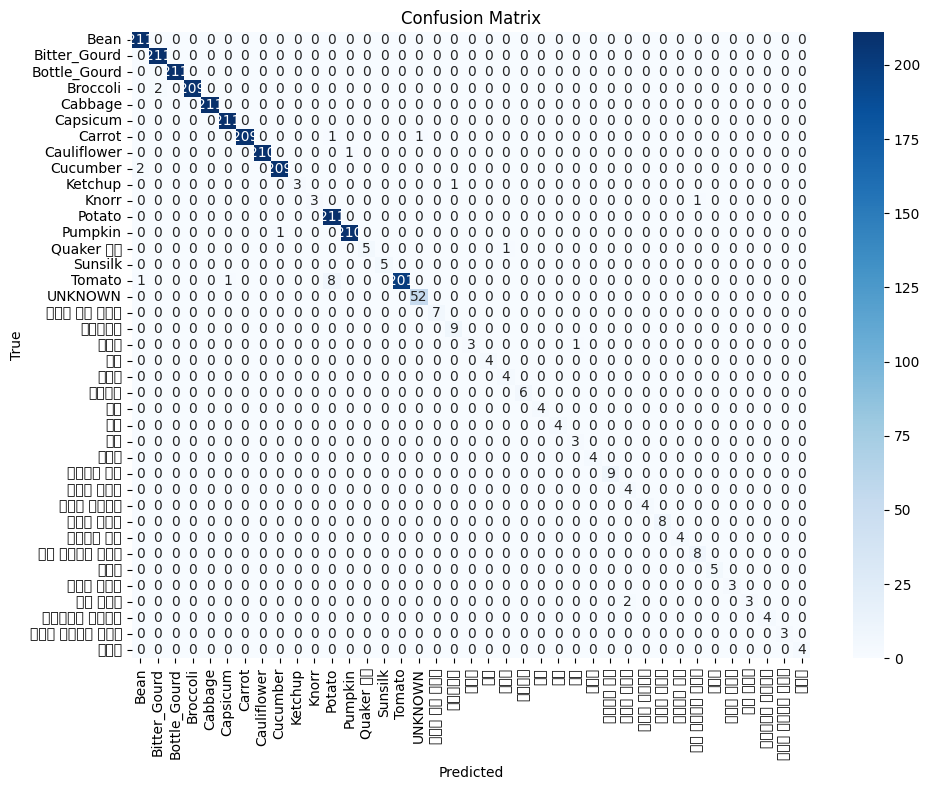

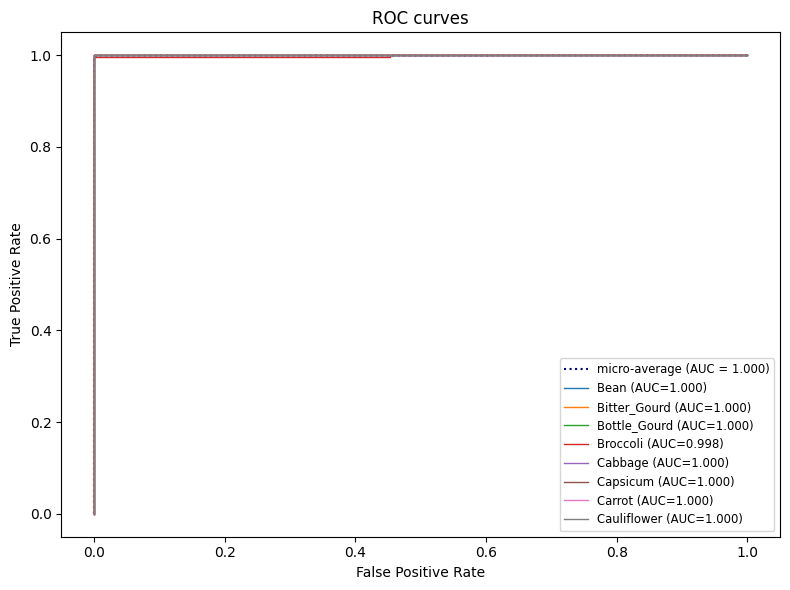

Wrote evaluation outputs to C:\Users\mommy\Documents\market-recognition\model\run_10epochs


In [6]:
# Full test-set evaluation (disabled by default)
# Set RUN_FULL_EVAL = True to run. This cell will:
# - Load the saved model
# - Run predictions on a `test` directory (one subfolder per class)
# - Save a JSON classification report, confusion matrix image, optional ROC curves, and sample predictions

RUN_FULL_EVAL = True

if RUN_FULL_EVAL:
    import json
    from pathlib import Path
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    import sklearn.metrics as metrics
    from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc  # type: ignore[attr-defined]
    from sklearn.preprocessing import label_binarize

    MODEL_PATH = Path(OUTPUT_DIR) / "product_classifier.keras"
    MODEL_PATH = Path(OUTPUT_DIR) / "product_classifier.keras"
    LABELS_PATH = Path(OUTPUT_DIR) / "labels.txt"
    OUT = Path(OUTPUT_DIR)
    OUT.mkdir(parents=True, exist_ok=True)

    if not MODEL_PATH.exists():
        raise FileNotFoundError(f"Model not found at {MODEL_PATH}")
    if not LABELS_PATH.exists():
        raise FileNotFoundError(f"labels.txt not found at {LABELS_PATH}")

    # Determine test dir
    CANDIDATES = [Path('./dataset/test'), Path(TRAIN_DIR).parent / 'test']
    TEST_DIR = next((p for p in CANDIDATES if p.exists()), CANDIDATES[0])
    if not TEST_DIR.exists():
        raise FileNotFoundError(f"Test directory not found. Searched: {CANDIDATES}")

    print('Loading model...')
    model = tf.keras.models.load_model(MODEL_PATH)

    datagen = ImageDataGenerator(rescale=1.0/255)
    test_gen = datagen.flow_from_directory(
        TEST_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    print('Predicting on test set...')
    probs = model.predict(test_gen, verbose=1)
    preds = probs.argmax(axis=1)
    truths = test_gen.classes

    labels = [None] * len(test_gen.class_indices)
    for k, v in test_gen.class_indices.items():
        labels[v] = k
    # Ensure labels are strings (no None) for plotting functions
    labels = [str(x) if x is not None else '' for x in labels]

    # Classification report
    report = classification_report(truths, preds, target_names=labels, output_dict=True)

    # Confusion matrix
    cm = confusion_matrix(truths, preds)

    # Top-k accuracy
    def top_k_accuracy(probs, truths, k=5):
        topk = np.argsort(probs, axis=1)[:, ::-1][:, :k]
        hits = [1 if truths[i] in topk[i] else 0 for i in range(len(truths))]
        return float(np.mean(hits))

    top1 = top_k_accuracy(probs, truths, k=1)
    top5 = top_k_accuracy(probs, truths, k=min(5, probs.shape[1]))

    summary = {
        'num_samples': int(test_gen.samples),
        'num_classes': int(test_gen.num_classes),
        'accuracy_top1': float(top1),
        'accuracy_top5': float(top5),
    }

    # Save results
    (OUT / 'eval_report.json').write_text(json.dumps({'summary': summary, 'report': report}, indent=2))
    np.save(OUT / 'confusion.npy', cm)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')  # type: ignore[arg-type]
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(OUT / 'confusion_matrix.png', dpi=150)
    plt.show()

    # ROC / AUC (multiclass) - optional
    try:
        # Ensure label_binarize returns a dense NumPy array (avoid sparse matrix issues)
        y_true_bin = np.asarray(label_binarize(truths, classes=range(len(labels))))
        n_classes = y_true_bin.shape[1]
        fpr = dict(); tpr = dict(); roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        # micro-average
        fpr['micro'], tpr['micro'], _ = roc_curve(np.ravel(y_true_bin), np.ravel(probs))
        roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

        # plot subset of curves
        plt.figure(figsize=(8,6))
        plt.plot(fpr['micro'], tpr['micro'], label=f"micro-average (AUC = {roc_auc['micro']:.3f})", color='navy', linestyle=':')
        for i in range(min(8, n_classes)):
            plt.plot(fpr[i], tpr[i], lw=1, label=f"{labels[i]} (AUC={roc_auc[i]:.3f})")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curves')
        plt.legend(loc='lower right', fontsize='small')
        plt.tight_layout()
        plt.savefig(OUT / 'roc_curves.png', dpi=150)
        plt.show()

        auc_out = {labels[i]: float(roc_auc[i]) for i in range(n_classes)}
        auc_out['micro'] = float(roc_auc['micro'])
        (OUT / 'auc_report.json').write_text(json.dumps(auc_out, indent=2))
    except Exception as e:
        print('Skipping ROC/AUC computation:', e)

    # Save a few sample images with predicted/actual in filename
    samples_out = OUT / 'samples'
    samples_out.mkdir(exist_ok=True)
    N = min(40, test_gen.samples)
    for i in range(N):
        src = Path(TEST_DIR) / test_gen.filenames[i]
        pred_label = labels[int(preds[i])]
        true_label = labels[int(truths[i])]
        dst = samples_out / f"{i:03d}__pred_{pred_label}__true_{true_label}__{src.name}"
        try:
            import shutil
            shutil.copy(src, dst)
        except Exception:
            pass

    print('Wrote evaluation outputs to', OUT)
else:
    print('RUN_FULL_EVAL is False — set to True to run a full test-set evaluation.')

## Documentation Template

Use this template to describe your run results (Project, Dataset, Model, Training, Evaluation, Testing, Conclusion). Fill in metrics and attach `model/eval_report.json`, `model/confusion_matrix.png`, and `model/roc_curves.png` if produced.

In [10]:
# Quick single-image test
from tensorflow.keras.preprocessing import image
from pathlib import Path

REPO_ROOT = Path(r"C:\Users\mommy\Documents\market-recognition")
SAMPLE_PATH = REPO_ROOT / 'dataset' / 'train' / 'bean' / '0001.jpg'  # change to any local file
labels_path = Path(OUTPUT_DIR) / "labels.txt"
model_path = Path(OUTPUT_DIR) / "product_classifier.keras"

if not SAMPLE_PATH.is_file():
    print("Update SAMPLE_PATH to point to a real image.")
elif not labels_path.is_file():
    print("labels.txt not found; train the model first.")
elif not model_path.exists():
    print("Saved model missing; train before testing.")
else:
    labels = labels_path.read_text(encoding="utf-8").splitlines()
    model = tf.keras.models.load_model(model_path)
    img = image.load_img(str(SAMPLE_PATH), target_size=IMG_SIZE)
    arr = image.img_to_array(img) / 255.0
    probs = model.predict(arr[None, ...])[0]
    idx = int(probs.argmax())
    print(f"Predicted: {labels[idx]} (p={probs[idx]:.3f})")


c:\Users\mommy\miniconda3\envs\marketrec\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted: Bean (p=1.000)


In [2]:
# Define notebook constants (run this first if kernel restarted)
from pathlib import Path
import os

# Set OUTPUT_DIR robustly (adjust path if your run folder differs)
OUTPUT_DIR = Path(
    r"C:\Users\mommy\Documents\market-recognition\model\run_10epochs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Common constants used by later cells
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load labels if available (used by correlation plot)
labels_path = OUTPUT_DIR / "labels.txt"
labels = labels_path.read_text(
    encoding="utf-8").splitlines() if labels_path.exists() else None

print("OUTPUT_DIR =", OUTPUT_DIR)
print("labels loaded:", bool(labels))

OUTPUT_DIR = C:\Users\mommy\Documents\market-recognition\model\run_10epochs
labels loaded: True


Summary:
{
  "num_samples": 2713,
  "num_classes": 39,
  "accuracy_top1": 0.9911537043862882,
  "accuracy_top5": 0.9996314043494287
}
Wrote per-class CSV to C:\Users\mommy\Documents\market-recognition\model\run_10epochs\f1_per_class.csv


,precision,recall,f1-score,support
Bottle_Gourd,1.0,1.0,1.0,211.0
Cabbage,1.0,1.0,1.0,211.0
ፈሳሽ የልብስ ሳሙና,1.0,1.0,1.0,3.0
ላይፍ ቦይ ሳሙና,1.0,1.0,1.0,7.0
በረኪና,1.0,1.0,1.0,6.0
ኦሞ,1.0,1.0,1.0,4.0
ሩዝ,1.0,1.0,1.0,4.0
ቪም,1.0,1.0,1.0,4.0
Sunsilk,1.0,1.0,1.0,5.0
ዲቶል,1.0,1.0,1.0,5.0


Loaded confusion matrix from C:\Users\mommy\Documents\market-recognition\model\run_10epochs\confusion.npy


c:\Users\mommy\miniconda3\envs\marketrec\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 4768 (\N{ETHIOPIC SYLLABLE GLOTTAL A}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\mommy\miniconda3\envs\marketrec\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 4867 (\N{ETHIOPIC SYLLABLE JAA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\mommy\miniconda3\envs\marketrec\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 4619 (\N{ETHIOPIC SYLLABLE LAA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\mommy\miniconda3\envs\marketrec\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 4845 (\N{ETHIOPIC SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\mommy\miniconda3\envs\marketrec\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 4941 (\N{ETHIOPIC SYLLABLE FE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\mommy\miniconda3\envs\marketrec\Lib\site-packages\seaborn

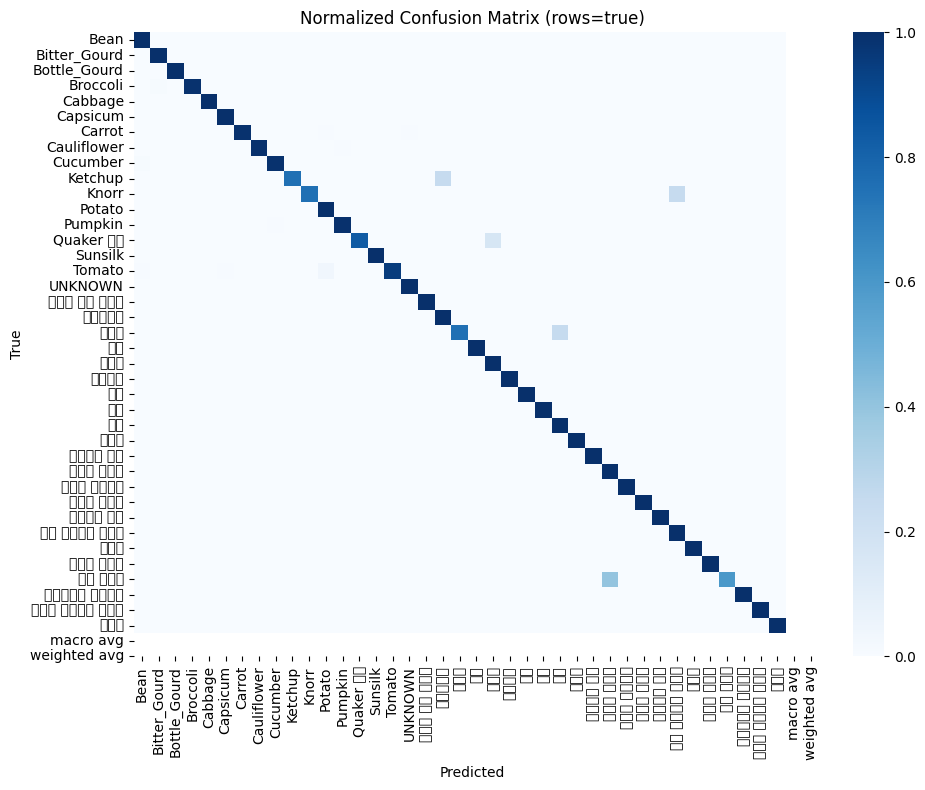

Wrote normalized confusion matrix to C:\Users\mommy\Documents\market-recognition\model\run_10epochs\confusion_matrix_normalized.png
No probs.npy found or `labels` not in notebook globals. To compute correlation, run and save `probs` earlier (e.g., np.save(OUT/'probs.npy', probs)).
Support vs F1 Pearson r/p: (np.float64(0.09777242997816264), np.float64(0.5430892135846808))
Support vs F1 Spearman rho/p: (np.float64(-0.12249228554180544), np.float64(0.44548877672629394))


C:\Users\mommy\AppData\Local\Temp\ipykernel_27940\608768248.py:103: UserWarning: Glyph 4768 (\N{ETHIOPIC SYLLABLE GLOTTAL A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mommy\AppData\Local\Temp\ipykernel_27940\608768248.py:103: UserWarning: Glyph 4867 (\N{ETHIOPIC SYLLABLE JAA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mommy\AppData\Local\Temp\ipykernel_27940\608768248.py:103: UserWarning: Glyph 4619 (\N{ETHIOPIC SYLLABLE LAA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mommy\AppData\Local\Temp\ipykernel_27940\608768248.py:103: UserWarning: Glyph 4845 (\N{ETHIOPIC SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mommy\AppData\Local\Temp\ipykernel_27940\608768248.py:103: UserWarning: Glyph 4941 (\N{ETHIOPIC SYLLABLE FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mommy\AppData\Local\Temp\ipykernel_27940\608768248.py:103: UserWarning: Glyph 4710 (\N{ETHIOPIC SYLLABLE BO}) mi

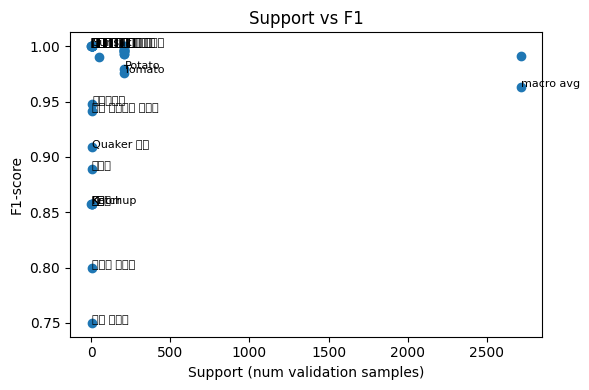

Wrote support vs F1 plot to C:\Users\mommy\Documents\market-recognition\model\run_10epochs\support_vs_f1.png


In [3]:
# --- Evaluation consolidation + correlation validation ---
# Paste after the main evaluation cell (requires OUT / eval_report.json and optionally probs.npy/confusion.npy)
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
OUT = Path(OUTPUT_DIR)  # reuse notebook OUTPUT_DIR constant
OUT.mkdir(parents=True, exist_ok=True)

# 1) Load eval_report.json
er_path = OUT / "eval_report.json"
if not er_path.exists():
    print("eval_report.json not found at", er_path)
else:
    er = json.loads(er_path.read_text(encoding="utf-8"))
    print("Summary:")
    print(json.dumps(er.get("summary", {}), indent=2))
    report = er.get("report", {})
    # extract per-class metrics (skip aggregates)
    per_class = {k: v for k, v in report.items() if isinstance(v, dict)}
    df = pd.DataFrame.from_dict(per_class, orient='index')
    # Ensure numeric columns
    for c in ['precision', 'recall', 'f1-score', 'support']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c])
    # Save CSV
    csv_out = OUT / "f1_per_class.csv"
    df.to_csv(csv_out, encoding="utf-8")
    print("Wrote per-class CSV to", csv_out)
    display(df.sort_values('f1-score', ascending=False).head(10))

# 2) Normalized confusion matrix (from confusion.npy or recompute if available)
conf_path = OUT / "confusion.npy"
cm = None
if conf_path.exists():
    cm = np.load(conf_path)
    print("Loaded confusion matrix from", conf_path)
else:
    print("No confusion.npy found; if you have preds/truths saved (probs.npy/preds.npy/truths.npy) you can recompute the matrix.")
if cm is not None:
    # normalize rows (true -> predicted)
    row_sums = cm.sum(axis=1, keepdims=True)
    norm_cm = cm.astype(float) / np.where(row_sums == 0, 1, row_sums)
    plt.figure(figsize=(10, 8))
    sns.heatmap(norm_cm, cmap='Blues', xticklabels=df.index,
                yticklabels=df.index, vmin=0, vmax=1)
    plt.title("Normalized Confusion Matrix (rows=true)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    nm_out = OUT / "confusion_matrix_normalized.png"
    plt.savefig(nm_out, dpi=150)
    plt.show()
    print("Wrote normalized confusion matrix to", nm_out)

# 3) Class prediction-probability correlation (requires probs.npy saved during evaluation)
probs_path = OUT / "probs.npy"
if probs_path.exists() and 'labels' in globals():
    probs = np.load(probs_path)
    print("Loaded probs:", probs.shape)
    # compute Pearson correlation between class probability columns
    corr = np.corrcoef(probs.T)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap='RdBu_r', center=0,
                xticklabels=labels, yticklabels=labels)
    plt.title("Class prediction-probability Pearson correlation")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    corr_out = OUT / "class_prediction_correlation.png"
    plt.savefig(corr_out, dpi=150)
    plt.show()
    print("Wrote class-prob correlation to", corr_out)
else:
    print("No probs.npy found or `labels` not in notebook globals. To compute correlation, run and save `probs` earlier (e.g., np.save(OUT/'probs.npy', probs)).")

# 4) Correlation between support and F1
if 'df' in locals() and 'f1-score' in df.columns and 'support' in df.columns:
    from scipy.stats import pearsonr, spearmanr
    supports = df['support'].astype(float).values
    f1s = df['f1-score'].astype(float).values
    if len(supports) >= 2:
        p_pear = pearsonr(supports, f1s)
        p_spear = spearmanr(supports, f1s)
        print("Support vs F1 Pearson r/p:", (p_pear[0], p_pear[1]))
        print("Support vs F1 Spearman rho/p:",
              (p_spear.correlation, p_spear.pvalue))
    else:
        print("Not enough classes to compute support-F1 correlation.")
    # scatter plot
    plt.figure(figsize=(6, 4))
    plt.scatter(supports, f1s)
    for i, lab in enumerate(df.index):
        if f1s[i] < 0.98 or supports[i] < 10:
            plt.text(supports[i], f1s[i], str(lab), fontsize=8)
    plt.xlabel("Support (num validation samples)")
    plt.ylabel("F1-score")
    plt.title("Support vs F1")
    plt.tight_layout()
    sf_out = OUT / "support_vs_f1.png"
    plt.savefig(sf_out, dpi=150)
    plt.show()
    print("Wrote support vs F1 plot to", sf_out)
else:
    print("Per-class dataframe not available to compute support-F1 correlation.")